# Todos:
- Build Beta prior distributions for shooting percentages on position by position basis.
- Build Gamma prior for each poisson distribution on position by position basis.
- Store the Beta and Gamma distribution for each player so that it is easy to update by exploiting conjugate prior property
- The positional Beta and Gamma priors should apply to each player at the beginning of their career.
- The Beta and Gamma priors should be adjusted to increase the variance at the beginning of each season due to the uncertainty of what happened during the offseason. (Note: for Gamma(a,b), $E[G] = \frac{a}{b}$ and $Var[G] = \frac{a}{b^2}$, so we can increase the variance while preserving the mean by multiplying $a$ and $b$ by some value $\lambda\in(0,1)$. Similarly for Beta(a,b), $E[B] = \frac{a}{b}$ and $Var[B] = \frac{ab}{(a+b)^2(a+b+1)}$. Multiplying $a$ and $b$ by $\lambda$ will preserve $E[B]$, but the Variance will increase since the denominator will be multiplied by $O(\lambda^2)$ and the numerator by $O(\lambda)$ making the denominator decrease by more than the numerator, and hence, increasing the variance.
- Write script to update and store these distributions for each statistic, for each player.
- Write script to fetch distributions to make a projection

In [1]:
%matplotlib inline
import player as data_pl
import team as data_te
import game as data_ga
import utils as anal_ut
import multiprocessing as mp
import numpy as np
import scipy
import scipy.stats as scst
import datetime
from numpy import linalg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.colors as colors
import pandas as pd
import time
from sklearn import cluster
from sklearn import linear_model
from collections import Counter
import math
import statsmodels.api as sm
import urllib2
import re
import os
import unicodedata
import time

In [2]:
## Converts Names from FanDuel's Player Sheet to Look Up-able names with the NBA API
FDPL2NBA = {
    'Brad Beal': 'Bradley Beal',
    'C.J. McCollum': 'CJ McCollum',
    'J.J. Redick': 'JJ Redick',
    'C.J. Miles': 'CJ Miles',
    'P.J. Tucker': 'PJ Tucker',
    'Nene Hilario': 'Nene',
    'Patrick Mills': 'Patty Mills',
    'T.J. Warren': 'TJ Warren',
    'Luc Richard Mbah a Moute': 'Luc Mbah a Moute',
    'C.J. Watson': 'CJ Watson',
    'C.J. Wilcox': 'CJ Wilcox',
    'Roy Devyn Marble': 'Devyn Marble',
    'K.J. McDaniels': 'KJ McDaniels',
    'T.J. McConnell': 'TJ McConnell',
    'Chuck Hayes': 'Charles Hayes',
    'Joseph Young': 'Joe Young',
    'Glenn Robinson III': 'Glenn Robinson',
    'Louis Amundson': 'Lou Amundson',
    
}

We can have a CSV file with rows of player parameters and other values.

Columns:
- Name
- Player ID (output of get_player(fname, lname))
- Position
- Current team
- For FG2%, FG3%, FT%, the Beta $\alpha$ and $\beta$ parameters
- For FG2A, FG3A, FTA, AST, REB, BLK, STL, TOV, the Gamma parameters $\alpha$ and $\beta$
- datetime of last update

# General Beta and Gamma Priors
Compute the p and lambda values for each player at each position that has played at least 50 minutes(?) in their career and compute the mean and variance. These will be used to set the alpha and beta in the Beta and Gamma distributions using the method of moments. This should only have to be run once per season.

In [3]:
pl = data_pl.PlayerList(season='2015-16', only_current=1).info()
table = pd.DataFrame()
MIN_THRESHOLD = 50
for name in pl.DISPLAY_LAST_COMMA_FIRST:
    try:
        pid = pl[pl.DISPLAY_LAST_COMMA_FIRST.str.lower() == name.lower()]['PERSON_ID'].tolist()[0]
        gl = data_pl.PlayerGameLogs(pid, season='2014-15').info()
    except Exception, exc:
        print exc.message
        print name
        continue
    mins = float(np.sum(gl.MIN))
    if mins < MIN_THRESHOLD:
        continue
    rates = {}
    for st in ('AST','BLK','STL','TOV','FG2A','FG3A','FTA','OREB','DREB'):
        if st == 'FG2A':
            rates[st] = np.sum(gl.FGA-gl.FG3A) / mins
        else:
            rates[st] = np.sum(gl[st]) / mins
    rates['FG2%'] = np.sum(gl.FGM-gl.FG3M) / float(np.sum(gl.FGA-gl.FG3A)) if float(np.sum(gl.FGA))>0 else 0
    rates['FG3%'] = np.sum(gl.FG3M) / float(np.sum(gl.FG3A)) if float(np.sum(gl.FG3A))>0 else 0
    rates['FT%'] = np.sum(gl.FTM) / float(np.sum(gl.FTA)) if float(np.sum(gl.FTA))>0 else 0
    table = table.append(pd.DataFrame(rates, index=[pid]))#, ignore_index=True)
table

,AST,BLK,DREB,FG2%,FG2A,FG3%,FG3A,FT%,FTA,OREB,STL,TOV
203112,0.052795,0.017081,0.172360,0.494465,0.210404,0.300000,0.046584,0.783505,0.075311,0.061335,0.020963,0.046584
203919,0.064516,0.028226,0.076613,0.409836,0.245968,0.400000,0.100806,0.608696,0.092742,0.036290,0.064516,0.056452
203500,0.037162,0.048423,0.182432,0.546599,0.223536,0.000000,0.001126,0.502439,0.115428,0.112050,0.021396,0.055743
201167,0.051559,0.002798,0.087930,0.466425,0.220224,0.354354,0.133094,0.843434,0.079137,0.010791,0.016387,0.046363
201582,0.049215,0.053403,0.220942,0.550152,0.344503,0.000000,0.000000,0.818182,0.103665,0.108901,0.021990,0.072251
202332,0.076766,0.066530,0.242579,0.478405,0.308086,0.000000,0.000000,0.781250,0.065507,0.103378,0.037871,0.060389
200746,0.049324,0.027049,0.218377,0.474809,0.521082,0.352381,0.041766,0.845304,0.143994,0.070406,0.019093,0.048528
202730,0.068480,0.039400,0.187617,0.471572,0.280488,0.000000,0.000000,0.702128,0.044090,0.115385,0.014071,0.037523
2754,0.052216,0.018215,0.107468,0.504695,0.258652,0.344828,0.017608,0.626984,0.076503,0.062538,0.078324,0.052216
202329,0.043129,0.045322,0.166667,0.484979,0.170322,0.274194,0.090643,0.711864,0.086257,0.083333,0.051170,0.040205


In [4]:
mean = np.mean(table, axis=0)
var = np.var(table, axis=0, ddof=1)

res = pd.DataFrame([mean, var], index=['mean','var'])

# MoM: E[p] = a/(a+b) => a = bE[p]/(1-E[p]) = b*m
# Var[p] = ab/( (a+b)^2 * (a+b+1) )
# Var[p] = mb^2 / ( b^2(m+1)^2 * (m*b+b+1) )
def B_beta(b, m, v):
    return m*b**2 / ( b**2 * (m+1)**2 * (b*m+b+1) ) - v

alphas = []
betas = []
# Beta
for st in ('FG2%','FG3%','FT%'):
    m, v = tuple(res[st].tolist())
    mp = m/(1-m)
    beta = scipy.optimize.fsolve(B_beta, .1, args=(mp, v), maxfev=1000)[0]
    alpha = mp*beta
    alphas.append(alpha)
    betas.append(beta)

# Gamma
for st in ('AST','BLK','OREB','DREB','TOV','STL','FG2A','FG3A','FTA'):
    m, v = res[st].tolist()
    beta = m/v
    alpha = m*beta
    alphas.append(alpha)
    betas.append(beta)
    
naive_beta_gamma_params = pd.DataFrame({'alpha':alphas, 'beta':betas}, 
                                       index=('FG2%','FG3%','FT%','AST','BLK',
                                            'OREB','DREB','TOV','STL','FG2A','FG3A','FTA'))
naive_beta_gamma_params

,alpha,beta
FG2%,31.366745,34.193048
FG3%,2.425142,6.380459
FT%,8.877789,3.172221
AST,2.271207,26.448806
BLK,1.022443,50.054241
OREB,1.716516,37.314868
DREB,6.182193,46.618068
TOV,6.859034,122.108549
STL,6.217947,196.181737
FG2A,6.836916,28.010169


# Create Beta and Gamma's for Each Player
Start each player with the naive_beta_gamma_params in their FROM_YEAR and update over one season. Then, at the beginning of each season, multiply all the $\alpha$ and $\beta$ by $\lambda\in(0,1)$ to preserve the expectation but inflate the variance. Repeat until current date.

The value of $\lambda$ to use for each of the distributions could be set by running a backtest and finding the value which has the lowest prediction error.

In [5]:
player_distributions = {}
# for row_ind in xrange(len(pl.PERSON_ID)):
#     row = pl.ix[row_ind]
#     pid = row.PERSON_ID
    dists = naive_beta_gamma_params.copy()
    mins = 150
    print '%3d: %d' % (row_ind, pid)
    
    for year in xrange(int(row.FROM_YEAR), int(row.TO_YEAR)+1):
        dists *= 150. / mins if mins > 150. else 1.
        
        if year == 2015:
            break
        
        season = '%d-%02d' % (year, year-2000+1 if year >= 2000 else (year - 1900 + 1) % 100)
        gl = data_pl.PlayerGameLogs(pid, season=season).info()
        
        mins = float(np.sum(gl.MIN))
        cts = {}
        for st in ('AST','BLK','STL','TOV','FG2A','FG2M','FG3A','FG3M','FTA','FTM','OREB','DREB'):
            if st == 'FG2A':
                cts[st] = np.sum(gl.FGA-gl.FG3A)
            elif st == 'FG2M':
                cts[st] = np.sum(gl.FGM-gl.FG3M)
            else:
                cts[st] = np.sum(gl[st])
        
        a = [cts['AST'], cts['BLK'], cts['STL'], cts['TOV'], cts['OREB'], cts['DREB'],
             cts['FG2M'],             cts['FG3M'],             cts['FTM'],
             cts['FG2A'], cts['FG3A'], cts['FTA']]
        b = [mins,       mins,       mins,       mins,       mins,        mins,       
             cts['FG2A']-cts['FG2M'], cts['FG3A']-cts['FG3M'], cts['FTA']-cts['FTM'], 
             mins,        mins,        mins]
        tmp = pd.DataFrame({'alpha':a, 'beta':b}, 
                    index=('AST','BLK','STL','TOV','OREB','DREB','FG2%','FG3%','FT%','FG2A','FG3A','FTA'))
        dists += tmp
    player_distributions[pid] = dists.copy()

player_distributions

  0: 203112
  1: 203919
  2: 203500
  3: 201167
  4: 201582
  5: 202332
  6: 200746
  7: 1626146
  8: 202730
  9: 2754
 10: 202329
 11: 200811
 12: 2365
 13: 101187
 14: 202341
 15: 1626147
 16: 203937
 17: 201583
 18: 203507
 19: 2546
 20: 201202
 21: 2772
 22: 201589
 23: 201600
 24: 201571
 25: 202337
 26: 203946
 27: 2571
 28: 200826
 29: 200745
 30: 203084
 31: 2440
 32: 203115
 33: 101138
 34: 201587
 35: 201573
 36: 203382
 37: 203145
 38: 203078
 39: 201158
 40: 203461
 41: 201976
 42: 202687
 43: 202357
 44: 204028
 45: 201971
 46: 2581
 47: 202339
 48: 202711
 49: 101106
 50: 2588
 51: 1626164
 52: 202344
 53: 2547
 54: 202340
 55: 201147
 56: 201166
 57: 1626148
 58: 203900
 59: 977
 60: 201978
 61: 203493
 62: 203504
 63: 202692
 64: 2406
 65: 202710
 66: 2446
 67: 203998
 68: 101181
 69: 203484
 70: 203477
 71: 203991
 72: 201960
 73: 1713
 74: 203487
 75: 201956
 76: 1626161
 77: 201596
 78: 2199
 79: 201163
 80: 1626176
 81: 203546
 82: 203903
 83: 202708
 84: 201954
 85

{708:           alpha        beta
 FG2%  26.540519   29.736130
 FG3%   0.161784    1.036420
 FT%    6.780431    1.688104
 AST   14.210838  177.196523
 BLK    3.650820  177.196523
 OREB   9.004595  177.196523
 DREB  48.759752  177.196523
 TOV    8.941312  177.196523
 STL    8.328546  177.196523
 FG2A  56.276649  177.196523
 FG3A   1.198204  177.196523
 FTA    8.468535  177.196523, 977:           alpha        beta
 FG2%  32.678125   45.744554
 FG3%   7.757062   19.055267
 FT%   29.169494    6.468989
 AST   31.065546  185.309108
 BLK    1.113607  185.309108
 OREB   3.815287  185.309108
 DREB  26.063415  185.309108
 TOV   21.084362  185.309108
 STL    7.165203  185.309108
 FG2A  78.422679  185.309108
 FG3A  26.812329  185.309108
 FTA   35.638483  185.309108, 1495:           alpha        beta
 FG2%  30.387959   28.963035
 FG3%   0.135570    0.362543
 FT%   16.686390    5.883531
 AST   16.612817  160.877267
 BLK   10.902290  160.877267
 OREB  12.253759  160.877267
 DREB  38.864861  160.87726

# Plot Distributions for Fun

          alpha        beta
FG2%  22.309357   20.040169
FG3%  17.251815   21.790424
FT%   18.655146    1.790628
AST   37.638197  159.092909
BLK    0.963003  159.092911
OREB   3.363566  159.092910
DREB   3.363566  159.092911
TOV   15.223365  159.092918
STL    9.765351  159.092925
FG2A  42.349520  159.092909
FG3A  39.042238  159.092908
FTA   20.445773  159.092910


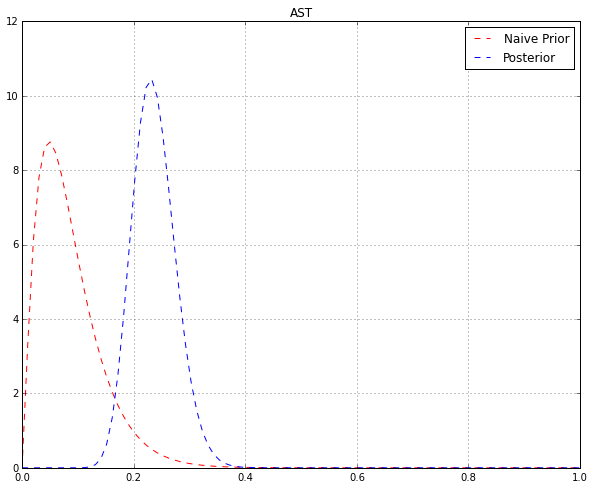

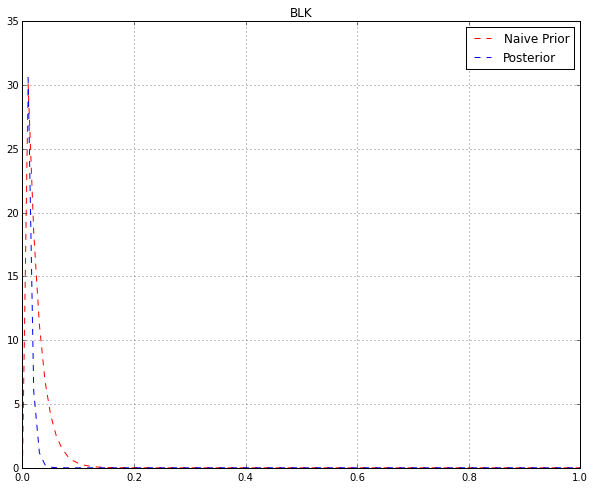

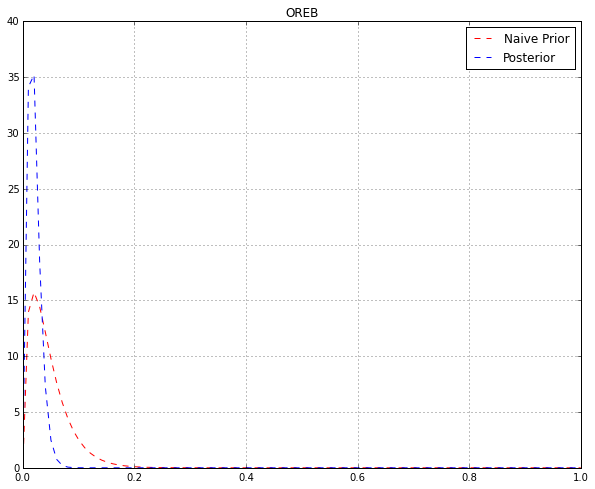

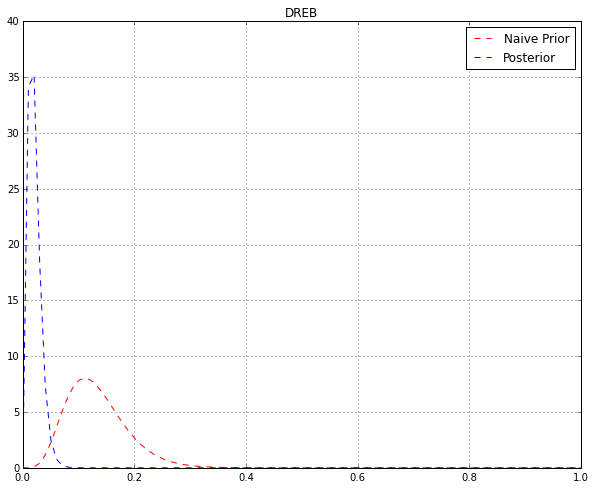

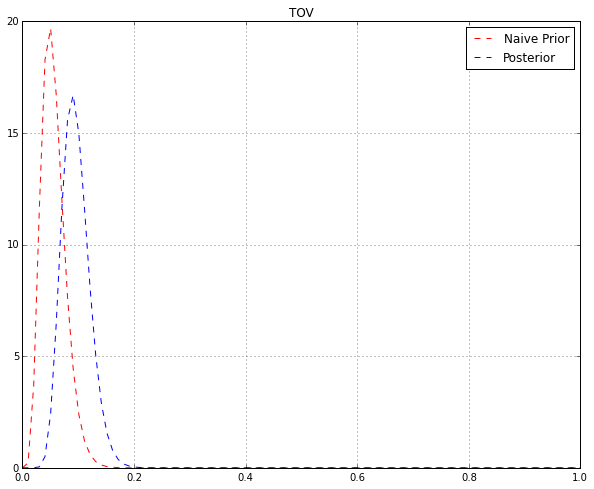

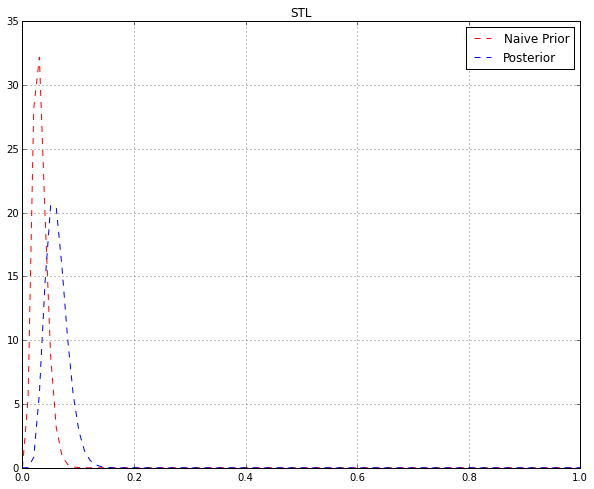

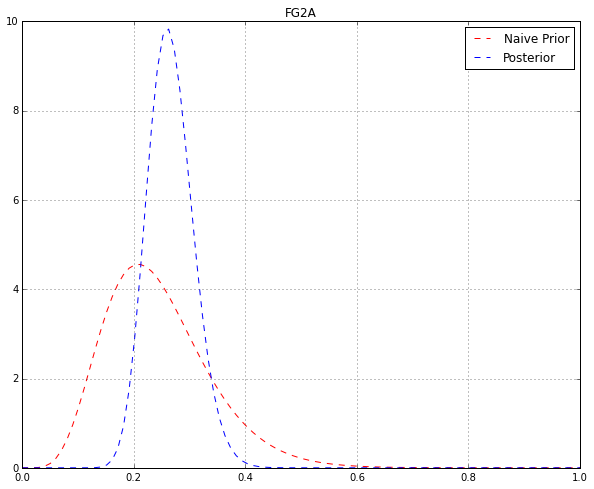

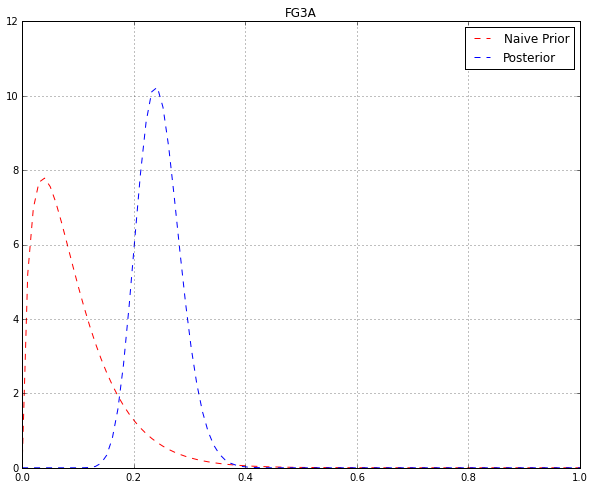

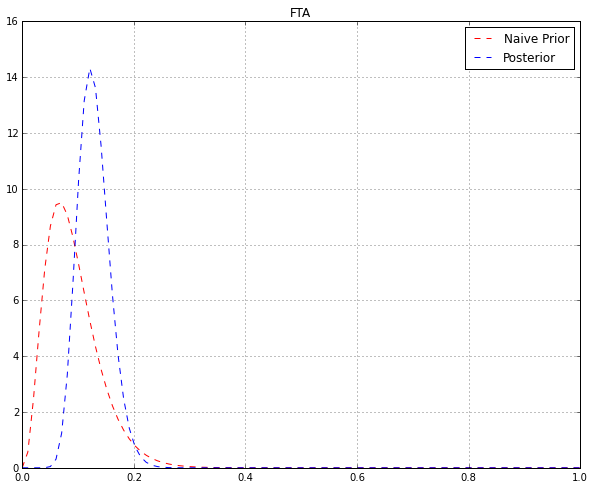

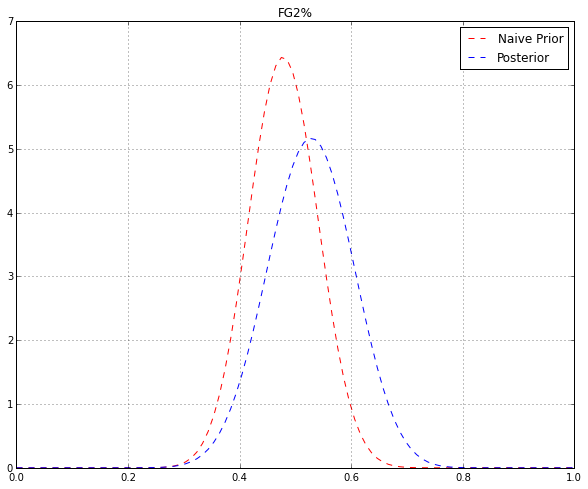

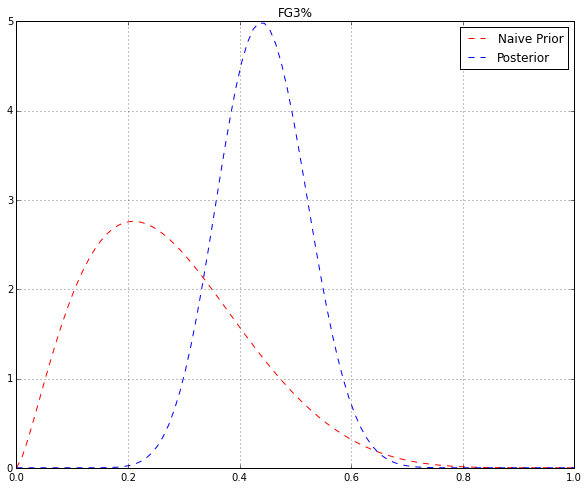

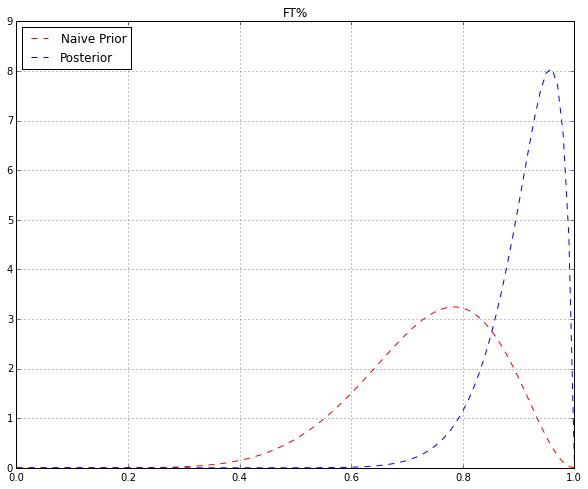

In [18]:
dist = player_distributions[data_pl.get_player('Stephen','Curry', season='2015-16', just_id=True).tolist()[0]]
print dist

for st in ('AST','BLK','OREB','DREB','TOV','STL','FG2A','FG3A','FTA'):
    x = np.linspace(0,1,100)
    a = dist.alpha.loc[st]
    b = dist.beta.loc[st]
    na = naive_beta_gamma_params.alpha[st]
    nb = naive_beta_gamma_params.beta[st]
    
    plt.plot(x, scst.gamma.pdf(x, na, scale=1./nb), 'r--', label='Naive Prior')
    plt.plot(x, scst.gamma.pdf(x, a, scale=1./b), 'b--', label='Posterior')
    plt.title(st)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

for st in ('FG2%','FG3%','FT%'):
    x = np.linspace(0,1,100)
    a = dist.alpha.loc[st]
    b = dist.beta.loc[st]
    na = naive_beta_gamma_params.alpha[st]
    nb = naive_beta_gamma_params.beta[st]
    
    plt.plot(x, scst.beta.pdf(x, na, nb), 'r--', label='Naive Prior')
    plt.plot(x, scst.beta.pdf(x, a, b), 'b--', label='Posterior')
    plt.title(st)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

# Write Distribution Parameters to File

In [6]:
# today = datetime.datetime.now().date()
today = datetime.date(2015,10,27)
filename = 'Parameters/player_parameters_%s.csv' % today

with open(filename, 'w') as writer:
    writer.write('PERSON_ID,%s' % ','.join(['%s_%s' % (param, st) for param in ('alpha','beta')
                for st in ('AST','BLK','STL','TOV','OREB','DREB','FG2%','FG3%','FT%','FG2A','FG3A','FTA')]))
    writer.write('\n')
    for row_ind in xrange(len(pl.PERSON_ID)):
        pid = pl.PERSON_ID.ix[row_ind]
        writer.write('%d,' % pid)
        
        for param in ('alpha','beta'):
            for st in ('AST','BLK','STL','TOV','OREB','DREB','FG2%','FG3%','FT%','FG2A','FG3A','FTA'):
                v = player_distributions[pid][param].loc[st]
                writer.write('%f,' % v)
        writer.write('\n')

# Read Distribution Parameters from File

In [4]:
today = datetime.datetime.now().date() - datetime.timedelta(days=1)
# today = datetime.date(2016,3,1)
filename = 'Parameters/player_parameters_%s.csv' % today

player_params = pd.read_csv(filename, index_col=False)
player_params = player_params.set_index('PERSON_ID')
player_params

,alpha_AST,alpha_BLK,alpha_STL,alpha_TOV,alpha_OREB,alpha_DREB,alpha_FG2%,alpha_FG3%,alpha_FT%,alpha_FG2A,...,beta_STL,beta_TOV,beta_OREB,beta_DREB,beta_FG2%,beta_FG3%,beta_FT%,beta_FG2A,beta_FG3A,beta_FTA
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
203112,24.614678,18.241304,21.790836,22.819822,56.966761,100.294267,78.534015,10.209445,33.930750,130.871826,...,693.325248,692.655601,691.889038,691.973142,52.868685,15.184095,11.907543,691.804920,691.716235,691.919411
203919,14.051133,4.852284,16.438274,14.616351,6.481764,17.231165,36.092789,7.515207,16.837372,46.030393,...,283.658309,238.855977,187.569476,193.196412,45.455473,13.931729,9.362230,181.941634,176.008188,189.601576
203500,52.052272,77.876082,28.697402,73.183478,187.324710,271.436045,209.640696,0.025603,102.627088,352.555711,...,1727.740094,1726.958072,1726.062868,1726.161086,143.534977,0.236280,71.250129,1725.964634,1725.861066,1726.098338
201167,123.658286,9.433016,23.591269,71.502443,17.738917,217.051536,255.671332,90.543823,122.025469,519.701764,...,2138.558831,2138.558831,2138.558831,2138.558831,264.030432,137.537137,17.085351,2138.558831,2138.558831,2138.558831
201582,28.529002,35.430792,16.118256,37.785836,69.954897,177.614990,121.872838,0.152963,45.511641,249.671119,...,770.001913,769.331676,768.564437,768.648615,128.329623,1.340779,10.266054,768.480245,768.391482,768.594837
202332,46.941800,48.233080,31.816127,47.475693,70.518476,164.639823,108.999302,0.056426,51.355807,204.063898,...,663.258496,661.535039,659.562149,659.778606,96.430898,0.148454,24.783947,659.345657,659.117409,659.640320
200746,98.076211,72.319491,25.102719,83.749780,154.192481,404.005365,465.570485,2.218817,223.377473,911.479235,...,2011.519194,2011.519194,2011.519194,2011.519194,445.908750,19.102785,38.584413,2011.519194,2011.519194,2011.519194
1626146,2.271207,3.022443,7.217947,7.859034,3.716516,10.182193,36.366745,2.425142,8.877789,16.836916,...,227.181737,153.108549,68.314868,77.618068,39.193048,6.380459,3.172221,59.010169,49.200204,71.674606
202730,74.820569,43.668077,24.635916,59.607400,152.963107,248.412519,184.862838,0.040564,35.380687,361.625177,...,1496.422146,1496.390431,1496.354125,1496.358108,176.787483,0.221904,21.338827,1496.350141,1496.345941,1496.355563


# Update Parameters

In [5]:
full_time = time.time()
while today < datetime.datetime.now().date():
    date = today.strftime('%b %d, %Y').upper()
    for pid in player_params.index.tolist():
        print pid
        try:
            gl = data_pl.PlayerGameLogs(pid, season='2015-16').info()
            gl = gl[gl.GAME_DATE == date]
            if len(gl.GAME_DATE) == 0:
                continue
            gl = gl.iloc[0]
        except KeyError:
            continue
        mins = gl.MIN
        for st in ('AST','OREB','DREB','BLK','STL','TOV','FG2A','FG3A','FTA'):
            if st == 'FG2A':
                player_params['alpha_FG2A'].loc[pid] += gl.FGA - gl.FG3A
                player_params['beta_FG2A'].loc[pid] += mins
                player_params['alpha_FG2%'].loc[pid] += gl.FGM - gl.FG3M
                player_params['beta_FG2%'].loc[pid] += gl.FGA - gl.FG3A - (gl.FGM - gl.FG3M)
            else:
                player_params['alpha_%s' % st].loc[pid] += gl[st]
                player_params['beta_%s' % st].loc[pid] += mins
            if st in ('FG3A','FTA'):
                s = st[:-1]
                player_params['alpha_%s%%' % s].loc[pid] += gl['%sM' % s]
                player_params['beta_%s%%' % s].loc[pid] += gl[st] - gl['%sM' % s]
    print date
    today += datetime.timedelta(days=1)
    filename = 'Parameters/player_parameters_%s.csv' % (today)
    player_params.to_csv(filename)
print 'Done Time Elapsed:', (time.time() - full_time)

203112
203919
203500
201167
201582
202332
200746
1626146
202730
2754
202329
200811
2365
101187
202341
1626147
203937
201583
203507
2546
201202
2772
201589
201600
201571
202337
203946
2571
200826
200745
203084
2440
203115
101138
201587
201573
203382
203145
203078
201158
203461
201976
202687
202357
204028
201971
2581
202339
202711
101106
2588
1626164
202344
2547
202340
201147
201166
1626148
203900
977
201978
203493
203504
202692
2406
202710
2446
203998
101181
203484
203477
203991
201960
1713
203487
201956
1626161
201596
2199
201163
1626176
203546
203903
202708
201954
2555
201144
1626192
203142
203955
202326
203496
203459
2037
203109
201967
203099
203552
201939
203584
203076
202334
1626183
201942
203473
1626155
203521
2736
2564
203476
203915
201962
201609
203083
201162
1626251
1495
2399
201142
203921
201961
101145
203954
203516
203898
202379
201936
203957
203105
202702
202324
1626245
101109
203095
200751
204025
202690
101112
201568
204038
708
201188
2200
200752
202087
202331
201959
1938
2

## Add Player to Bayesian Parameters

In [44]:
pid = 1626214
gl = data_pl.PlayerGameLogs(pid, season='2015-16').info()
mins = gl.MIN
for st in ('AST','OREB','DREB','BLK','STL','TOV','FG2A','FG3A','FTA'):
    if st == 'FG2A':
        player_params.set_value(pid, 'alpha_FG2A', gl.FGA.sum() - gl.FG3A.sum())
        player_params.set_value(pid, 'beta_FG2A', mins.sum())
        player_params.set_value(pid, 'alpha_FG2%', gl.FGM.sum() - gl.FG3M.sum())
        player_params.set_value(pid, 'beta_FG2%', gl.FGA.sum() - gl.FG3A.sum() - (gl.FGM.sum() - gl.FG3M.sum()))
    else:
        player_params.set_value(pid, 'alpha_%s' % st, gl[st].sum())
        player_params.set_value(pid, 'beta_%s' % st, mins.sum())
    if st in ('FG3A','FTA'):
        s = st[:-1]
        player_params.set_value(pid, 'alpha_%s%%' % s, gl['%sM' % s].sum())
        player_params.set_value(pid, 'beta_%s%%' % s, gl[st].sum() - gl['%sM' % s].sum())

In [47]:
filename = 'Parameters/player_parameters_%s.csv' % (today)
player_params.to_csv(filename)